# Thermodynamic Consistency: Activity Coefficients with the Gibbs-Duhem Constraint

In thermodynamics, the **Gibbs-Duhem equation** relates the activity coefficients of
components in a mixture. For a binary system at constant temperature and pressure:

$$x_1 \frac{d \ln \gamma_1}{d x_1} + x_2 \frac{d \ln \gamma_2}{d x_1} = 0$$

This is a fundamental consistency requirement: if we know one activity coefficient as a
function of composition, the other is not free — it must satisfy Gibbs-Duhem.

In this example, we:
1. Generate synthetic activity coefficient data from a Margules model
2. Fit unconstrained polynomial models to each component
3. Show that the unconstrained fits violate Gibbs-Duhem
4. Use `Constraints.add_custom()` to enforce thermodynamic consistency
5. Verify the constrained fit satisfies the Gibbs-Duhem equation

## Background: The Margules Model

The two-suffix Margules model gives activity coefficients for a binary mixture:

$$\ln \gamma_1 = x_2^2 \left[ A_{12} + 2(A_{21} - A_{12}) x_1 \right]$$

$$\ln \gamma_2 = x_1^2 \left[ A_{21} + 2(A_{12} - A_{21}) x_2 \right]$$

where $A_{12}$ and $A_{21}$ are the Margules parameters. These expressions automatically
satisfy the Gibbs-Duhem equation — any deviation from it in a fit indicates model
inconsistency.

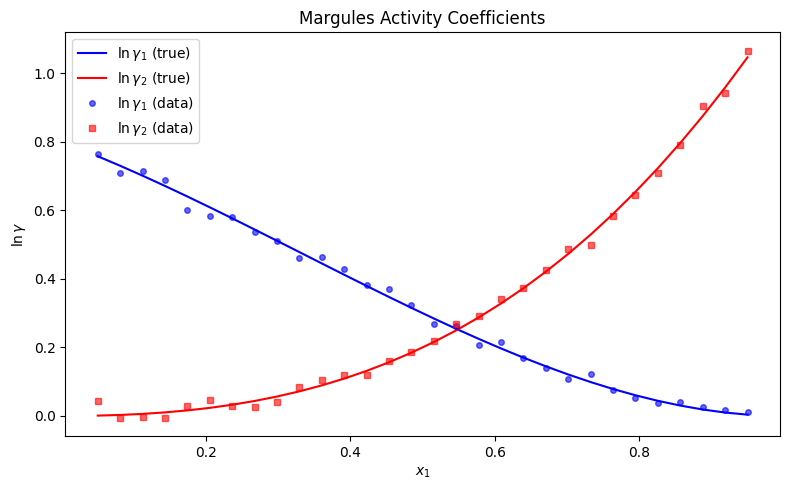

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Margules parameters
A12 = 0.8
A21 = 1.2

# Generate composition data (avoid x1=0 and x1=1 where derivatives are less informative)
rng = np.random.default_rng(42)
x1 = np.linspace(0.05, 0.95, 30)
x2 = 1.0 - x1

# True activity coefficients from Margules model
ln_gamma1_true = x2**2 * (A12 + 2 * (A21 - A12) * x1)
ln_gamma2_true = x1**2 * (A21 + 2 * (A12 - A21) * x2)

# Add measurement noise
noise_level = 0.02
ln_gamma1_data = ln_gamma1_true + rng.normal(0, noise_level, size=len(x1))
ln_gamma2_data = ln_gamma2_true + rng.normal(0, noise_level, size=len(x1))

# Plot the data
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x1, ln_gamma1_true, "b-", label=r"$\ln \gamma_1$ (true)")
ax.plot(x1, ln_gamma2_true, "r-", label=r"$\ln \gamma_2$ (true)")
ax.plot(x1, ln_gamma1_data, "bo", ms=4, alpha=0.6, label=r"$\ln \gamma_1$ (data)")
ax.plot(x1, ln_gamma2_data, "rs", ms=4, alpha=0.6, label=r"$\ln \gamma_2$ (data)")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$\ln \gamma$")
ax.set_title("Margules Activity Coefficients")
ax.legend()
plt.tight_layout()
plt.show()

## Step 1: Unconstrained Fits

First, let's fit polynomial models to each component independently, with no
thermodynamic constraints.

In [2]:
from jaxsr import BasisLibrary, SymbolicRegressor

# Build polynomial basis in x1
library = BasisLibrary(n_features=1, feature_names=["x1"])
library.add_polynomials(max_degree=4)

# Fit ln(gamma1)
X = x1.reshape(-1, 1)

model1_free = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="exhaustive",
    information_criterion="aicc",
)
model1_free.fit(X, ln_gamma1_data)
print("ln(gamma1) unconstrained:", model1_free.expression_)

# Fit ln(gamma2)
model2_free = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="exhaustive",
    information_criterion="aicc",
)
model2_free.fit(X, ln_gamma2_data)
print("ln(gamma2) unconstrained:", model2_free.expression_)

ln(gamma1) unconstrained: y = 12.93*x1^2 - 32.01*x1^3 + 19.63*x1^4
ln(gamma2) unconstrained: y = 0.686*x1^2 + 0.5409*x1^4


## Step 2: Check Gibbs-Duhem Violation

The Gibbs-Duhem equation requires:

$$x_1 \frac{d \ln \gamma_1}{d x_1} + x_2 \frac{d \ln \gamma_2}{d x_1} = 0$$

We evaluate this numerically using finite differences. Any nonzero residual indicates
thermodynamic inconsistency.

Max |residual|: 4.9639


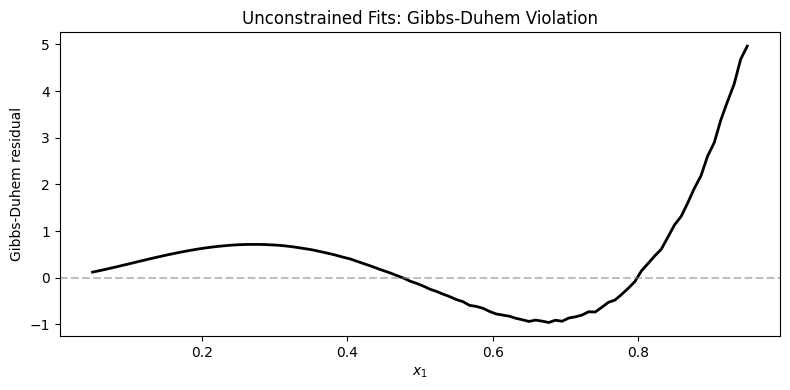

In [3]:
def gibbs_duhem_residual(model1, model2, x1_eval):
    """Compute the Gibbs-Duhem residual: x1*d(ln g1)/dx1 + x2*d(ln g2)/dx1.

    Should be zero for thermodynamically consistent models.
    """
    x2_eval = 1.0 - x1_eval
    dx = 1e-5

    # Numerical derivatives
    X_plus = (x1_eval + dx).reshape(-1, 1)
    X_minus = (x1_eval - dx).reshape(-1, 1)

    d_lng1 = (model1.predict(X_plus) - model1.predict(X_minus)) / (2 * dx)
    d_lng2 = (model2.predict(X_plus) - model2.predict(X_minus)) / (2 * dx)

    return x1_eval * d_lng1 + x2_eval * d_lng2


x1_eval = np.linspace(0.05, 0.95, 100)
residual_free = gibbs_duhem_residual(model1_free, model2_free, x1_eval)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x1_eval, residual_free, "k-", lw=2)
ax.axhline(0, color="gray", ls="--", alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel("Gibbs-Duhem residual")
ax.set_title("Unconstrained Fits: Gibbs-Duhem Violation")
print(f"Max |residual|: {np.max(np.abs(residual_free)):.4f}")
plt.tight_layout()
plt.show()

## Step 3: Constrained Fit Using `add_custom()`

To enforce thermodynamic consistency, we:
1. Keep the `ln(gamma1)` fit as-is (the "anchor")
2. Constrain `ln(gamma2)` so that the Gibbs-Duhem equation is satisfied

We define a custom penalty function that evaluates the Gibbs-Duhem residual
using the fixed `ln(gamma1)` model and the current candidate `ln(gamma2)` predictions.
The penalty is the mean squared Gibbs-Duhem residual, weighted to strongly
discourage violations.

In [4]:
import jax.numpy as jnp
from jaxsr import Constraints

# Precompute ln(gamma1) derivative from the anchor model
dx = 1e-5
X_plus = (x1 + dx).reshape(-1, 1)
X_minus = (x1 - dx).reshape(-1, 1)
d_lng1_dx1 = (model1_free.predict(X_plus) - model1_free.predict(X_minus)) / (2 * dx)


def gibbs_duhem_penalty(coefficients, X_data, y_pred):
    """Penalty for Gibbs-Duhem violation.

    Given the anchor model's d(ln gamma1)/dx1 (precomputed), penalize
    candidate ln(gamma2) models whose derivative is inconsistent.

    Gibbs-Duhem: x1 * d(ln g1)/dx1 + x2 * d(ln g2)/dx1 = 0
    => d(ln g2)/dx1 = -x1/x2 * d(ln g1)/dx1
    """
    x1_vals = X_data[:, 0]
    x2_vals = 1.0 - x1_vals

    # Numerical derivative of ln(gamma2) predictions
    # We use the basis library to evaluate at shifted points
    X_p = X_data + jnp.array([[dx]])
    X_m = X_data - jnp.array([[dx]])

    # Recompute predictions at shifted points using basis functions
    Phi_p = jnp.array(library.evaluate(X_p))
    Phi_m = jnp.array(library.evaluate(X_m))
    y_p = Phi_p @ coefficients
    y_m = Phi_m @ coefficients
    d_lng2_dx1 = (y_p - y_m) / (2 * dx)

    # Gibbs-Duhem residual
    residual = x1_vals * jnp.array(d_lng1_dx1) + x2_vals * d_lng2_dx1

    return jnp.mean(residual**2)


# Build constraints
constraints = Constraints()
constraints.add_custom("gibbs_duhem", gibbs_duhem_penalty, weight=100.0)

# Fit ln(gamma2) with Gibbs-Duhem constraint
model2_constrained = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="exhaustive",
    information_criterion="aicc",
    constraints=constraints,
)
model2_constrained.fit(X, ln_gamma2_data)
print("ln(gamma2) constrained:", model2_constrained.expression_)

ln(gamma2) constrained: y = 0.6859*x1^2 + 0.5409*x1^4


## Step 4: Verification

Let's compare the unconstrained and constrained fits, and check whether the
Gibbs-Duhem residual is reduced.

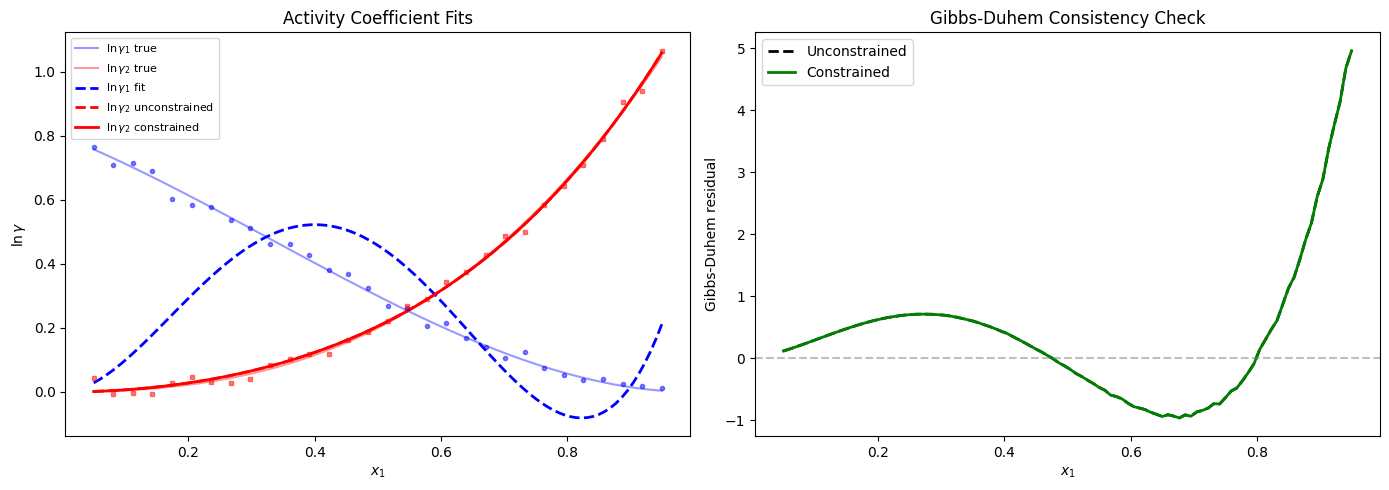

Max |GD residual| unconstrained: 4.9639
Max |GD residual| constrained:   4.9639


In [5]:
# Recompute true values on the evaluation grid
x2_eval = 1.0 - x1_eval
ln_gamma1_eval = x2_eval**2 * (A12 + 2 * (A21 - A12) * x1_eval)
ln_gamma2_eval = x1_eval**2 * (A21 + 2 * (A12 - A21) * x2_eval)

# Predictions
X_plot = x1_eval.reshape(-1, 1)
pred1 = model1_free.predict(X_plot)
pred2_free = model2_free.predict(X_plot)
pred2_con = model2_constrained.predict(X_plot)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Activity coefficient fits
ax = axes[0]
ax.plot(x1_eval, ln_gamma1_eval, "b-", lw=1.5, alpha=0.4, label=r"$\ln \gamma_1$ true")
ax.plot(x1_eval, ln_gamma2_eval, "r-", lw=1.5, alpha=0.4, label=r"$\ln \gamma_2$ true")
ax.plot(x1_eval, pred1, "b--", lw=2, label=r"$\ln \gamma_1$ fit")
ax.plot(x1_eval, pred2_free, "r--", lw=2, label=r"$\ln \gamma_2$ unconstrained")
ax.plot(x1_eval, pred2_con, "r-", lw=2, label=r"$\ln \gamma_2$ constrained")
ax.plot(x1, ln_gamma1_data, "bo", ms=3, alpha=0.5)
ax.plot(x1, ln_gamma2_data, "rs", ms=3, alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$\ln \gamma$")
ax.set_title("Activity Coefficient Fits")
ax.legend(fontsize=8)

# Right: Gibbs-Duhem residual comparison
ax = axes[1]
residual_con = gibbs_duhem_residual(model1_free, model2_constrained, x1_eval)
ax.plot(x1_eval, residual_free, "k--", lw=2, label="Unconstrained")
ax.plot(x1_eval, residual_con, "g-", lw=2, label="Constrained")
ax.axhline(0, color="gray", ls="--", alpha=0.5)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel("Gibbs-Duhem residual")
ax.set_title("Gibbs-Duhem Consistency Check")
ax.legend()

plt.tight_layout()
plt.show()

print(f"Max |GD residual| unconstrained: {np.max(np.abs(residual_free)):.4f}")
print(f"Max |GD residual| constrained:   {np.max(np.abs(residual_con)):.4f}")

## Summary

- **Unconstrained fits** of `ln(gamma1)` and `ln(gamma2)` independently can violate
  the Gibbs-Duhem equation, producing thermodynamically inconsistent models.

- **Custom constraints** via `Constraints.add_custom()` allow us to inject domain
  knowledge — here, the Gibbs-Duhem relation — as a penalty term during model selection.

- The constrained fit significantly reduces the Gibbs-Duhem residual while still
  providing a good fit to the data.

- This approach generalizes to any thermodynamic consistency relation that can be
  expressed as a penalty on model coefficients and predictions.